# Investigating double descent

Its been observed with large models, where the number of parameters > number of datapoints, that we dont see the expected rise in test error when we start to overfit.

*   https://openai.com/blog/deep-double-descent/
*   https://medium.com/mlearning-ai/double-descent-8f92dfdc442f
*   https://mlu-explain.github.io/double-descent/
*   https://mlu-explain.github.io/double-descent2/

This is quite confusing... it seems that in some cases we see test performance starts to degrade before getting better again and then surpassing its previous peak performance.
Can we show this happening with simple synthetic data?

I will generate some dummy data of noisy sinusiods and then attempt to overfit to it.

In [1]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

Let's generate some sinusiod based data:

/var/folders/yq/ddhnc0l57fv0ws1v2qjb0l900000gn/T/ipykernel_55366/3601814711.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


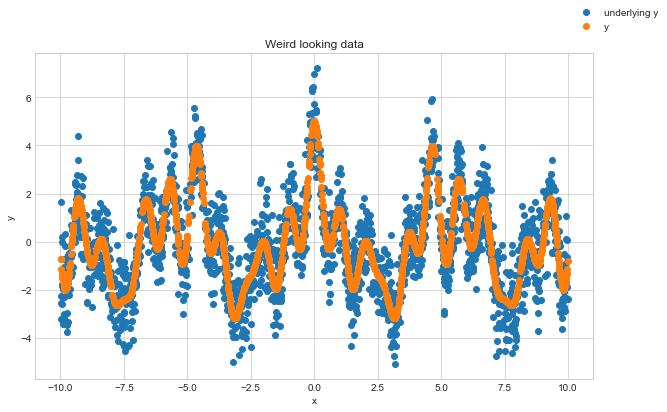

In [146]:
rand_gen = np.random.default_rng(seed=0)

n = 2000
n_freq = 5
freqs = rand_gen.uniform(low=1, high=8, size=(n_freq, 1))

x = rand_gen.uniform(-10, 10, size=(n, 1))

y_raw = np.zeros((n, 1))
for freq in freqs:
    y_raw = y_raw + np.cos(x * freq)

# add noise
y = y_raw + rand_gen.normal(scale=1.0, size=(n, 1))

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y, label='underlying y')
ax.scatter(x, y_raw, label='y')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Weird looking data")
fig.legend()
fig.show()

Next we generate some feature of other random sinusoids.

In [147]:
rand_gen = np.random.default_rng(seed=1)
n_features = 2000

if 0:
    feature_freqs = rand_gen.uniform(low=1, high=8, size=(n_features,1))

    x_features = []
    for feature_freq in feature_freqs:
        x_features.append(np.cos(x*feature_freq))
    x_features = np.concatenate(x_features, axis=1)
else:
    x_features = rand_gen.normal(size=(n, n_features))
x_features.shape

(2000, 2000)

## Fit models
Next we fit a linear regression models with increaing number of features. We would expect to see increasing overfit with increasing feature numbers.

In [148]:
# split data
x_train = x[: n // 2]
x_test = x[n // 2 :]
x_features_train = x_features[: n // 2]
x_features_test = x_features[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]

In [149]:
import sklearn.linear_model
import sklearn.metrics
import tqdm

feature_no_range = range(1, n_features, 10)
mse_train = []
mse_test = []
for feature_no in tqdm.tqdm(feature_no_range):
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_features_train[:, :feature_no], y_train)

    y_est_train = model.predict(x_features_train[:, :feature_no])
    y_est_test = model.predict(x_features_test[:, :feature_no])

    mse_train.append(sklearn.metrics.mean_squared_error(y_train, y_est_train))
    mse_test.append(sklearn.metrics.mean_squared_error(y_test, y_est_test))

100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


## Inspecting results

Plotting the MSE against feature count shows a surprising result that MSE increases as we overfit, but then reduces again when more and more features are added.

/var/folders/yq/ddhnc0l57fv0ws1v2qjb0l900000gn/T/ipykernel_55366/4155385395.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


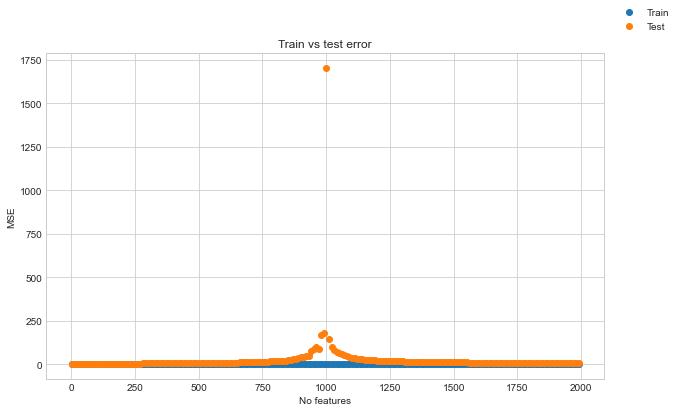

In [150]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(feature_no_range, mse_train, label='Train')
ax.scatter(feature_no_range, mse_test, label='Test')
ax.set_xlabel("No features")
ax.set_ylabel("MSE")
ax.set_title("Train vs test error")
fig.legend()
fig.show()

/var/folders/yq/ddhnc0l57fv0ws1v2qjb0l900000gn/T/ipykernel_55366/3166980005.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


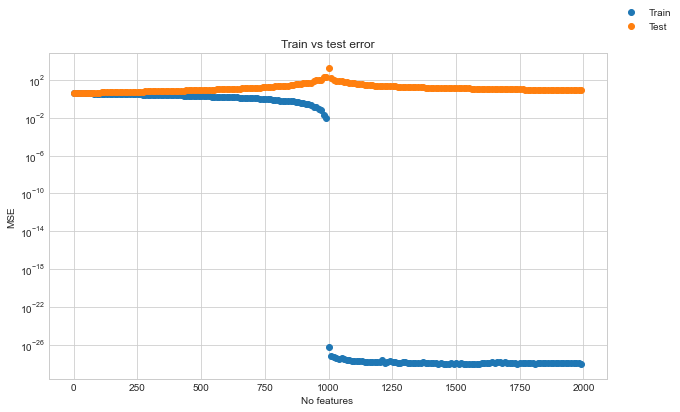

In [154]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(feature_no_range, mse_train, label='Train')
ax.scatter(feature_no_range, mse_test, label='Test')
ax.set_yscale('log')
ax.set_xlabel("No features")
ax.set_ylabel("MSE")
ax.set_title("Train vs test error")
fig.legend()
fig.show()

Inspecting results on the train and test sets at different points.
We plot the training estimates on the left and the test estimates on the right for increasing numbers of features.

100%|██████████| 7/7 [00:01<00:00,  5.20it/s]
/var/folders/yq/ddhnc0l57fv0ws1v2qjb0l900000gn/T/ipykernel_55366/926330916.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


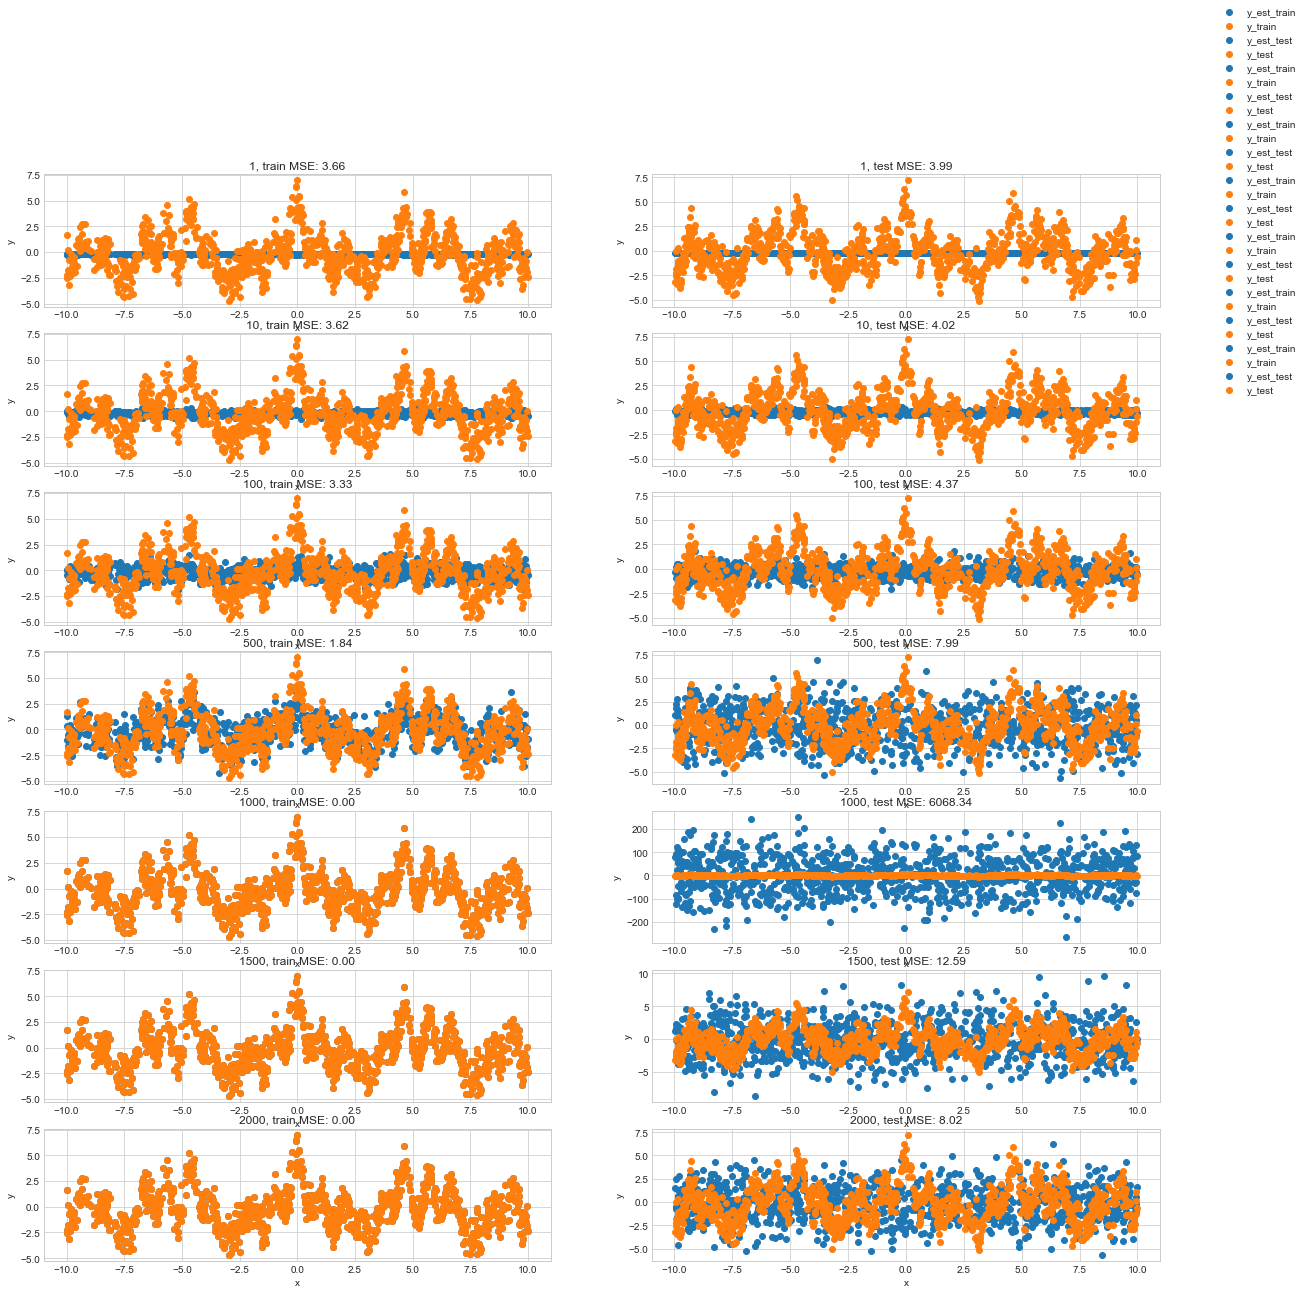

In [158]:

feature_no_range_plot = [1, 10, 100, 500, 1000, 1500, 2000]

fig, ax = plt.subplots(nrows=len(feature_no_range_plot), ncols=2, figsize=(20,20))

for idx, feature_no in enumerate(tqdm.tqdm(feature_no_range_plot)):
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_features_train[:, :feature_no], y_train)

    y_est_train = model.predict(x_features_train[:, :feature_no])
    y_est_test = model.predict(x_features_test[:, :feature_no])

    ax[idx, 0].scatter(x_train, y_est_train, label='y_est_train')
    ax[idx, 0].scatter(x_train, y_train, label='y_train')
    ax[idx, 0].set_xlabel("x")
    ax[idx, 0].set_ylabel("y")
    ax[idx, 0].set_title(f"{feature_no}, train MSE: {sklearn.metrics.mean_squared_error(y_train, y_est_train):.2f}")

    ax[idx, 1].scatter(x_test, y_est_test, label='y_est_test')
    ax[idx, 1].scatter(x_test, y_test, label='y_test')
    ax[idx, 1].set_xlabel("x")
    ax[idx, 1].set_ylabel("y")
    ax[idx, 1].set_title(f"{feature_no}, test MSE: {sklearn.metrics.mean_squared_error(y_test, y_est_test):.2f}")

fig.legend()
fig.show()


When the number of features > number of data points we see essentially perfect reconstruction of the training data. As such the training MSE tends towards 0. And this doesn't change when we add even more features.
On the test set however we see that the estimates become less noisy again after we introduce more and more features.